<a href="https://colab.research.google.com/github/arunangshu19/PINN/blob/main/Allen_Cahn_2%2B1_doublestage_pde_annealing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cuda:0

--- Stage 1: IC only for 20000 iterations ---
IC Stage Iter 0, Loss: 0.520982
IC Stage Iter 1000, Loss: 0.403616
IC Stage Iter 2000, Loss: 0.207601
IC Stage Iter 3000, Loss: 0.073956
IC Stage Iter 4000, Loss: 0.027191
IC Stage Iter 5000, Loss: 0.012292
IC Stage Iter 6000, Loss: 0.003630
IC Stage Iter 7000, Loss: 0.002141
IC Stage Iter 8000, Loss: 0.001323
IC Stage Iter 9000, Loss: 0.001143
IC Stage Iter 10000, Loss: 0.000368
IC Stage Iter 11000, Loss: 0.000365
IC Stage Iter 12000, Loss: 0.000310
IC Stage Iter 13000, Loss: 0.000324
IC Stage Iter 14000, Loss: 0.000252
IC Stage Iter 15000, Loss: 0.000374
IC Stage Iter 16000, Loss: 0.000153
IC Stage Iter 17000, Loss: 0.000460
IC Stage Iter 18000, Loss: 0.000117
IC Stage Iter 19000, Loss: 0.000101

--- Stage 2: PDE only (annealed weight) for 20000 iterations ---
PDE Stage Iter 0, Loss: 5.620821, lambda_pde=0.0000
PDE Stage Iter 1000, Loss: 0.001817, lambda_pde=0.2000
PDE Stage Iter 2000, Loss: 0.000274, lambda_pde=0.40

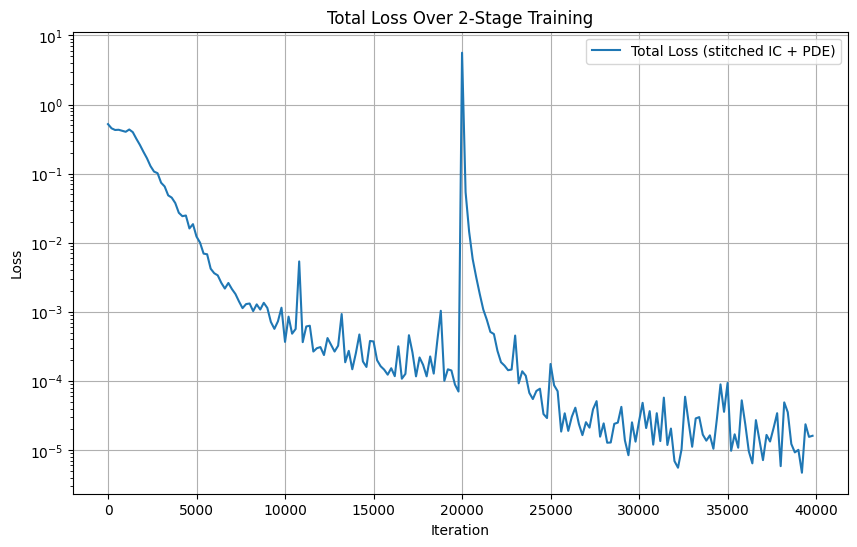

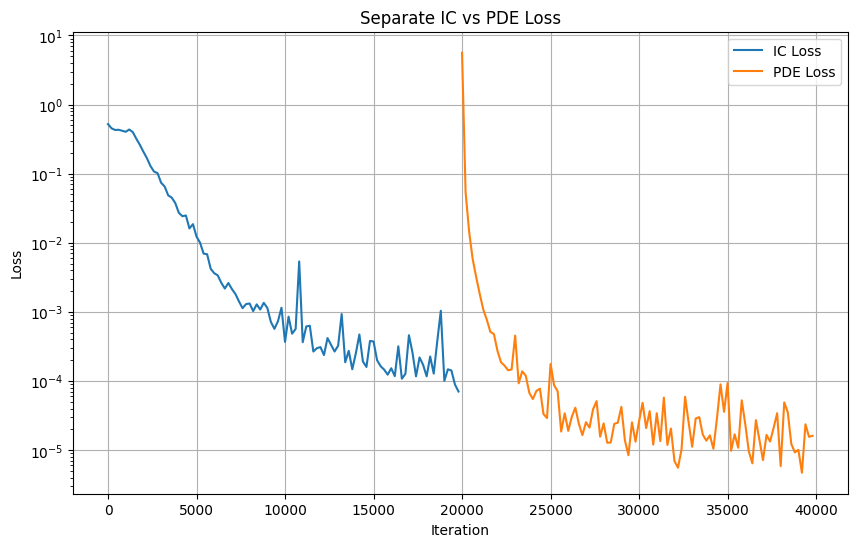


Plotting evaluation...


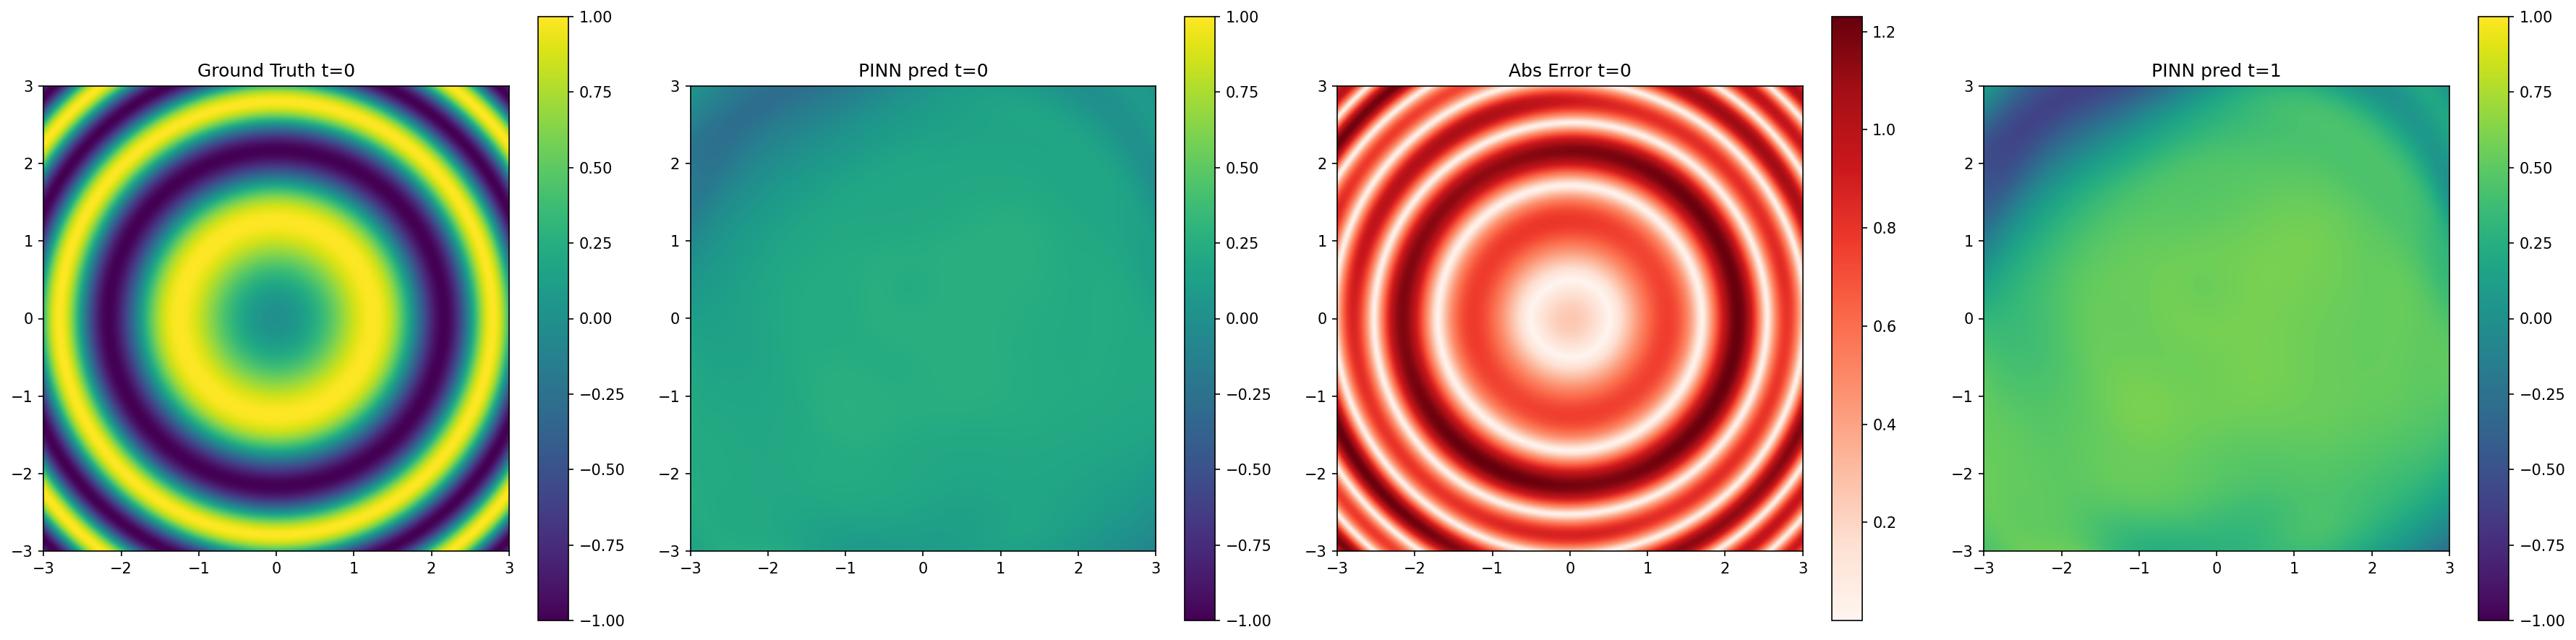


Plotting time evolution...


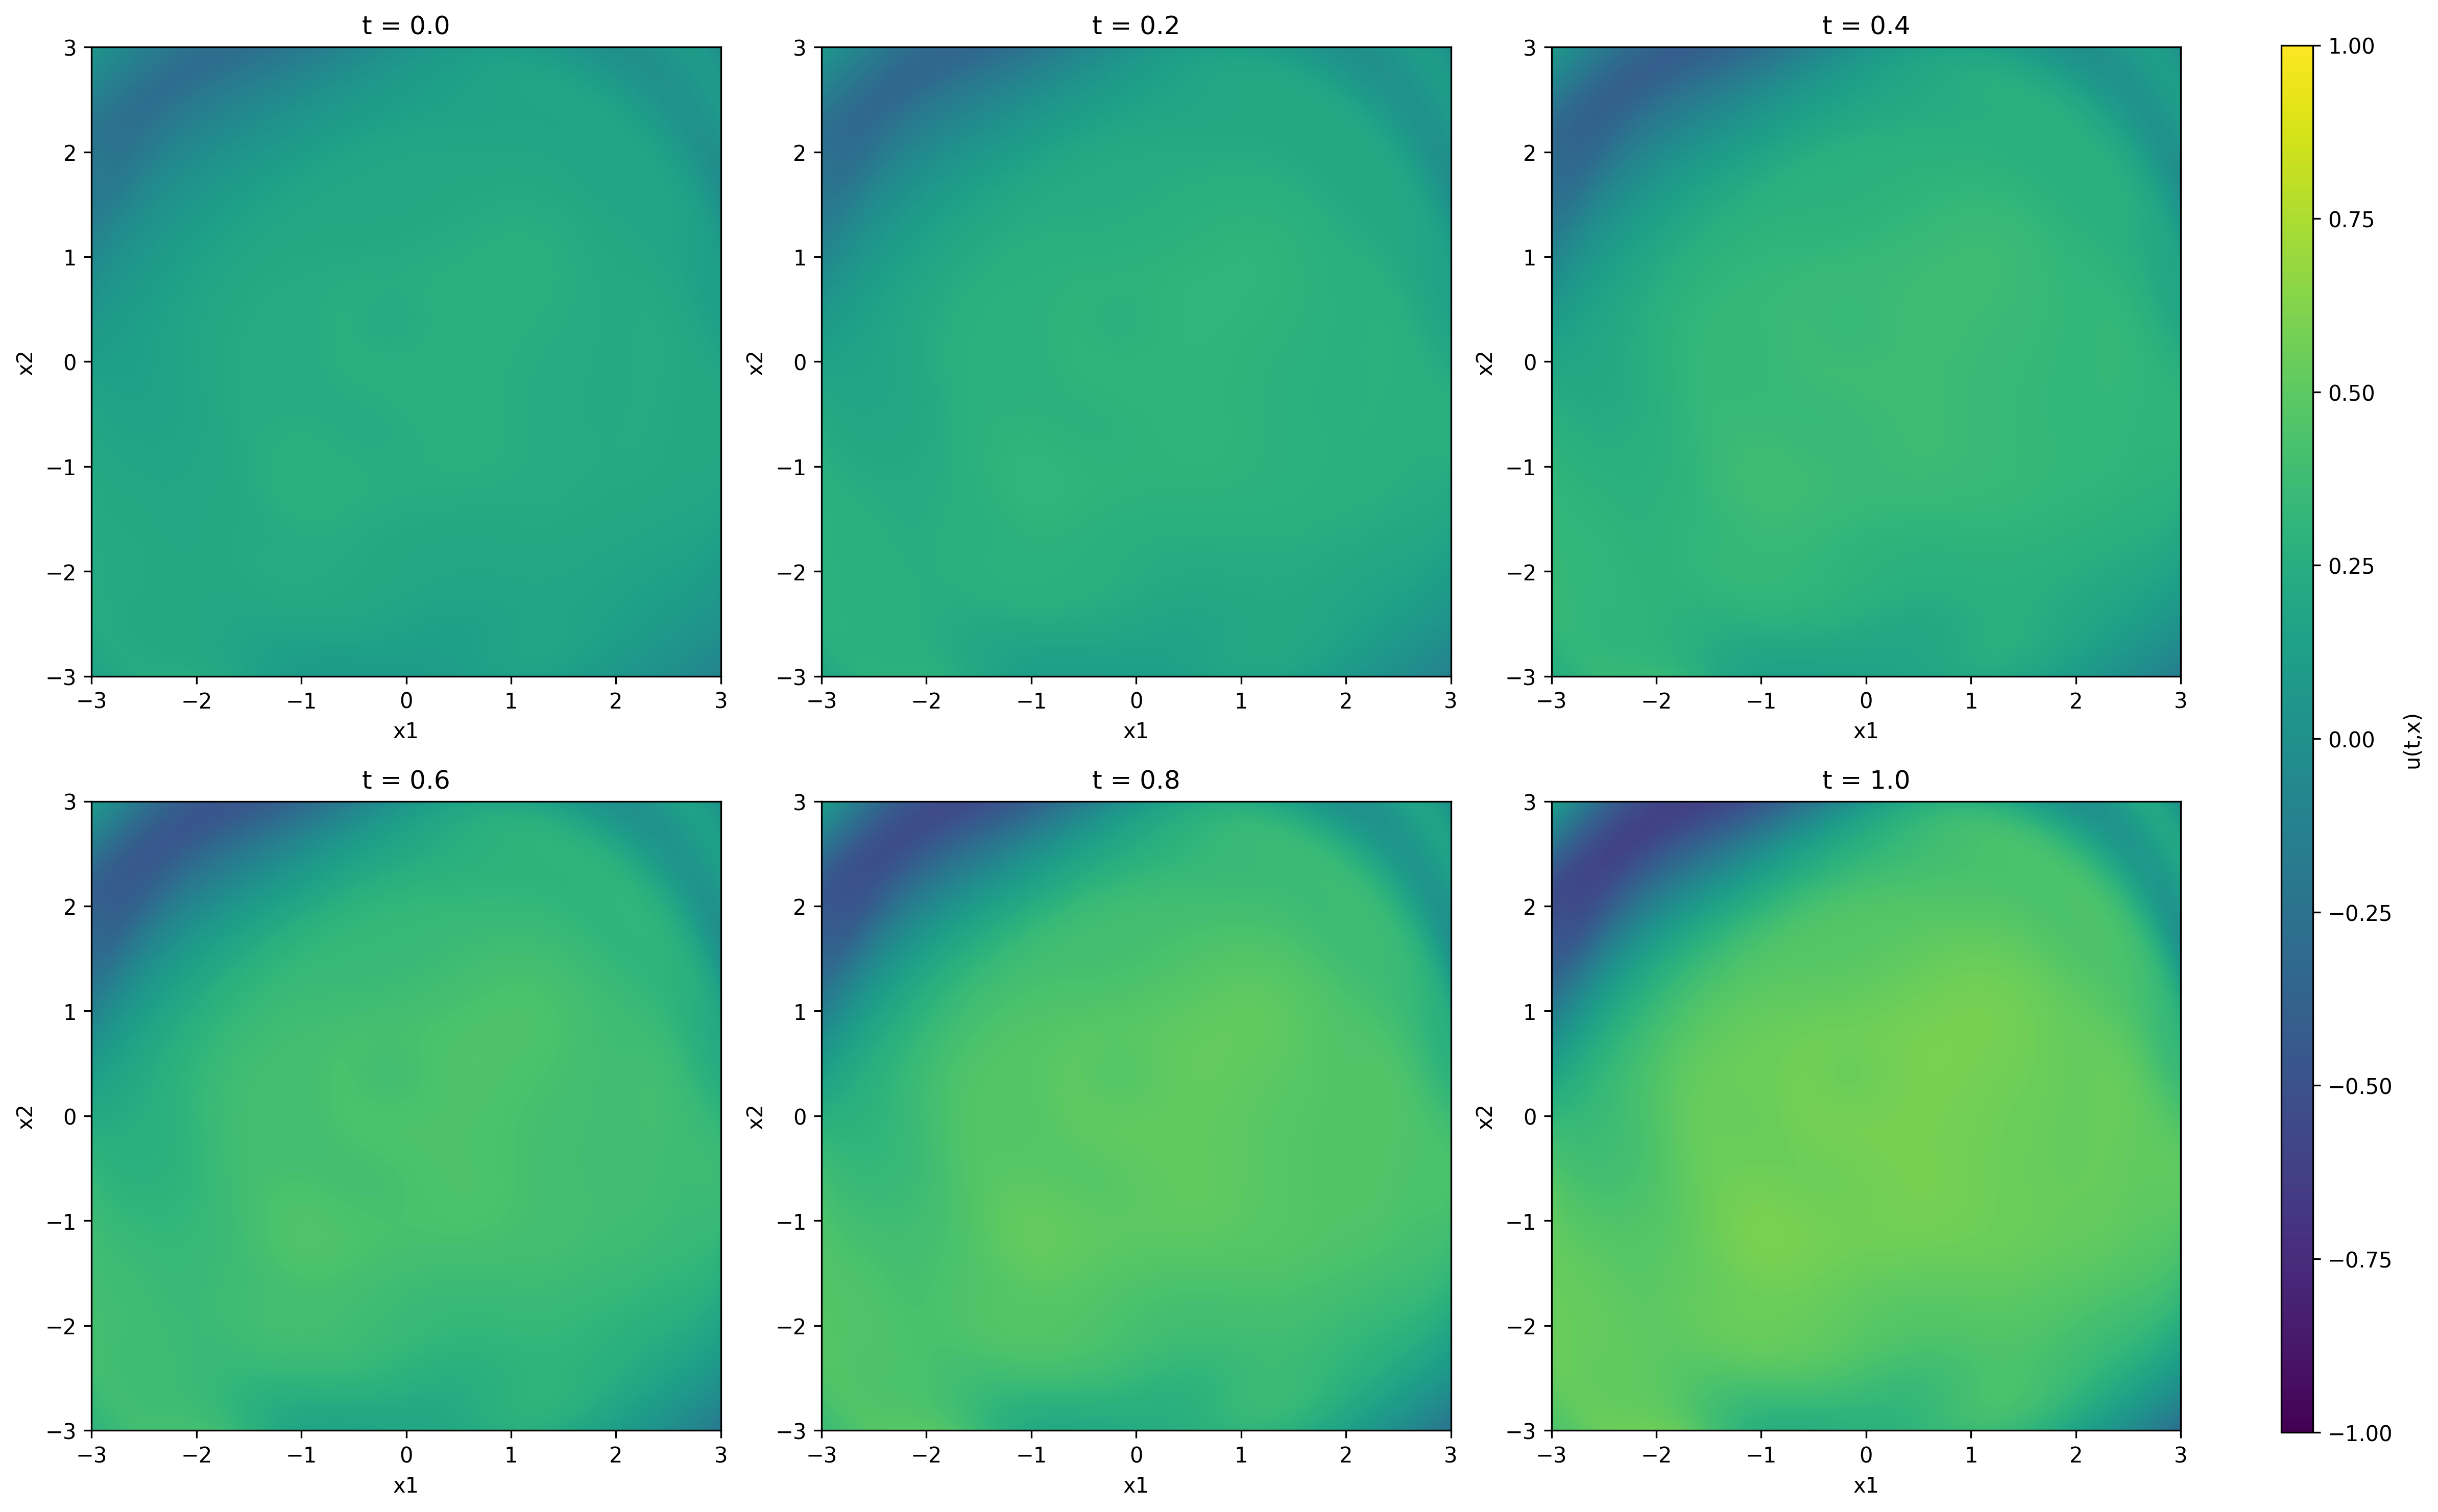

In [ ]:
# --- Imports ---
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.autograd import grad
from matplotlib.gridspec import GridSpec
from matplotlib.cm import ScalarMappable
import time
import random

# --- Reproducibility ---
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

SEED = 42
set_seed(SEED)

# --- Device ---
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {dev}")

# --- Sine activation ---
class Sine(torch.nn.Module):
    def forward(self, x):
        return torch.sin(x)

# --- Parameters ---
T = 1.0
M_pde = 20000
M_initial = 20000

# --- Data ---
x_pde_train = (torch.rand(M_pde, 2, device=dev) * 6) - 3
t_pde_train = torch.rand(M_pde, 1, device=dev) * T
x_initial_train = (torch.rand(M_initial, 2, device=dev) * 6) - 3

# --- IC function ---
def phi(x):
    return torch.sin(torch.sum(x**2, dim=1, keepdim=True))

# --- Network ---
hidden = 256
N = torch.nn.Sequential(
    torch.nn.Linear(3, hidden), Sine(),
    torch.nn.Linear(hidden, hidden), Sine(),
    torch.nn.Linear(hidden, hidden), Sine(),
    torch.nn.Linear(hidden, hidden), Sine(),
    torch.nn.Linear(hidden, 1)
).to(dev)

# --- Optimizer ---
optimizer = torch.optim.Adam(N.parameters(), lr=1e-4)

# --- Hyperparams ---
J_pde = 1024
J_ic = 1024
k_pretrain = 20000
k_main = 20000

# --- Stage 1: IC only ---
print(f"\n--- Stage 1: IC only for {k_pretrain} iterations ---")
ic_loss_history = []
for i in range(k_pretrain):
    optimizer.zero_grad()

    idx_ic = torch.randint(0, M_initial, (J_ic,))
    x_ic = x_initial_train[idx_ic]
    t_ic = torch.zeros_like(x_ic[:, :1])
    u0_pred = N(torch.hstack((t_ic, x_ic)))
    loss_ic = (u0_pred - phi(x_ic)).square().mean()

    loss_ic.backward()
    optimizer.step()

    if i % 200 == 0:
        ic_loss_history.append(loss_ic.item())
        if i % 1000 == 0:
            print(f"IC Stage Iter {i}, Loss: {loss_ic.item():.6f}")

# --- Stage 2: PDE only with annealing ---
print(f"\n--- Stage 2: PDE only (annealed weight) for {k_main} iterations ---")
pde_loss_history = []
pde_weight_anneal_steps = 5000.0  # adjust if you like
for i in range(k_main):
    optimizer.zero_grad()

    # anneal PDE weight from 0 to 1 smoothly
    lambda_pde = min(1.0, i / pde_weight_anneal_steps)

    idx_pde = torch.randint(0, M_pde, (J_pde,))
    x_c = x_pde_train[idx_pde]
    t_c = t_pde_train[idx_pde]
    x1_c, x2_c = x_c[:, 0:1], x_c[:, 1:2]
    x1_c.requires_grad_()
    x2_c.requires_grad_()
    t_c.requires_grad_()

    u = N(torch.hstack((t_c, x1_c, x2_c)))
    u_t = grad(u, t_c, torch.ones_like(u), create_graph=True)[0]
    u_x1 = grad(u, x1_c, torch.ones_like(u), create_graph=True)[0]
    u_x2 = grad(u, x2_c, torch.ones_like(u), create_graph=True)[0]
    u_x1x1 = grad(u_x1, x1_c, torch.ones_like(u_x1), create_graph=True)[0]
    u_x2x2 = grad(u_x2, x2_c, torch.ones_like(u_x2), create_graph=True)[0]
    pde_res = u_t - (0.005*(u_x1x1 + u_x2x2) + u - u**3)
    loss_pde = pde_res.square().mean()

    total_loss = lambda_pde * loss_pde  # IC stays out of stage 2

    total_loss.backward()
    optimizer.step()

    if i % 200 == 0:
        pde_loss_history.append(loss_pde.item())
        if i % 1000 == 0:
            print(f"PDE Stage Iter {i}, Loss: {loss_pde.item():.6f}, lambda_pde={lambda_pde:.4f}")

# --- Combine total loss history for plotting
total_loss_history = ic_loss_history + pde_loss_history

# --- Plot total stitched loss
plt.figure(figsize=(10,6))
plt.plot(np.arange(len(total_loss_history))*200, total_loss_history, label="Total Loss (stitched IC + PDE)")
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.title("Total Loss Over 2-Stage Training")
plt.show()

# --- Plot separate losses for reference
plt.figure(figsize=(10,6))
plt.plot(np.arange(len(ic_loss_history))*200, ic_loss_history, label="IC Loss")
plt.plot(np.arange(len(pde_loss_history))*200 + k_pretrain, pde_loss_history, label="PDE Loss")
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.title("Separate IC vs PDE Loss")
plt.show()

# --- Evaluation
N.eval()
print("\nPlotting evaluation...")

mesh = 256
a, b = -3, 3
xg, yg = torch.meshgrid(
    torch.linspace(a,b,mesh,device=dev),
    torch.linspace(a,b,mesh,device=dev),
    indexing="xy"
)
xy_flat = torch.cat((xg.reshape(-1,1), yg.reshape(-1,1)), dim=1)

z_true = phi(xy_flat).cpu().numpy().reshape(mesh, mesh)
with torch.no_grad():
    t_zero = torch.zeros_like(xy_flat[:, :1])
    u0_pred = N(torch.cat((t_zero, xy_flat), dim=1)).cpu().numpy().reshape(mesh, mesh)
    t_final = torch.ones_like(xy_flat[:, :1]) * T
    u1_pred = N(torch.cat((t_final, xy_flat), dim=1)).cpu().numpy().reshape(mesh, mesh)

fig, axs = plt.subplots(1,4,figsize=(24,6),dpi=150)

im0 = axs[0].imshow(z_true, extent=[a,b,a,b], cmap="viridis", vmin=-1,vmax=1)
axs[0].set_title("Ground Truth t=0")
plt.colorbar(im0, ax=axs[0])

im1 = axs[1].imshow(u0_pred, extent=[a,b,a,b], cmap="viridis", vmin=-1,vmax=1)
axs[1].set_title("PINN pred t=0")
plt.colorbar(im1, ax=axs[1])

err = np.abs(z_true - u0_pred)
im2 = axs[2].imshow(err, extent=[a,b,a,b], cmap="Reds")
axs[2].set_title("Abs Error t=0")
plt.colorbar(im2, ax=axs[2])

im3 = axs[3].imshow(u1_pred, extent=[a,b,a,b], cmap="viridis", vmin=-1,vmax=1)
axs[3].set_title("PINN pred t=1")
plt.colorbar(im3, ax=axs[3])

plt.tight_layout()
plt.show()

# --- Time evolution
print("\nPlotting time evolution...")
time_steps = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
fig2 = plt.figure(figsize=(16,10), dpi=300)
gs = GridSpec(2,4,width_ratios=[1,1,1,0.05])

for idx, tval in enumerate(time_steps):
    with torch.no_grad():
        t_plot = torch.full((mesh**2,1), tval, device=dev)
        u_plot = N(torch.cat((t_plot, xy_flat), dim=1)).cpu().numpy().reshape(mesh, mesh)

    ax = fig2.add_subplot(gs[idx//3, idx%3])
    ax.set_title(f"t = {tval:.1f}")
    im = ax.imshow(u_plot, extent=[a,b,a,b], cmap="viridis", vmin=-1,vmax=1)
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")

from matplotlib.colors import Normalize
norm = Normalize(vmin=-1,vmax=1)
sm = ScalarMappable(norm=norm, cmap="viridis")
cax = fig2.add_subplot(gs[:,3])
fig2.colorbar(sm, cax=cax, orientation="vertical", label="u(t,x)")

plt.tight_layout()
plt.show()